# Temperature Modelling

In [61]:
import os
import numpy as np
from scipy import signal
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta

### Dataset

Construct our daily average temperature dataset

In [3]:
max_daily_dataset = nc.Dataset('../../datasets/tasmax_hadukgrid_uk_region_day_19600101-20211231.nc')
min_daily_dataset = nc.Dataset('../../datasets/tasmin_hadukgrid_uk_region_day_19600101-20211231.nc')
region = 10

In [4]:
def convert_hours_to_datetime(hours):
    base_date = datetime(1800, 1, 1, 0, 0, 0)  # Base date for the calculation
    delta = timedelta(hours=hours)  # Create a timedelta based on the hours
    # Add the timedelta to the base date to get the resulting datetime
    result_datetime = base_date + delta
    return result_datetime.date()

In [5]:
region_daily_min = min_daily_dataset['tasmin'][:, region]
region_daily_max = max_daily_dataset['tasmax'][:, region]
data_dict = {'min': region_daily_min, 'max': region_daily_max, 'time': min_daily_dataset['time'][:]}
df = pd.DataFrame(data=data_dict)
df['date'] = df['time'].apply(convert_hours_to_datetime)
df['avg'] = (df['min'] + df['max'])/2
pass

In [6]:
df[['min', 'max', 'avg']].describe()

min           max           avg
count  22646.000000  22646.000000  22646.000000
mean       4.730455     11.302974      8.016714
std        4.530745      5.085901      4.600439
min      -14.254959     -5.087061     -8.319792
25%        1.349252      7.462394      4.470683
50%        4.870896     11.244147      8.021019
75%        8.299387     15.171387     11.729068
max       16.404600     27.929750     21.080322

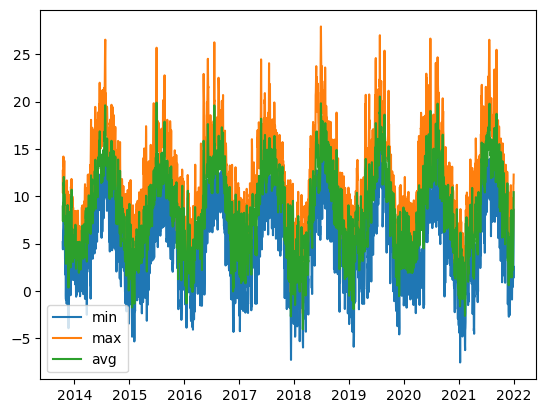

In [7]:
plt.plot(df['date'][-3000:], df['min'][-3000:], label="min")
plt.plot(df['date'][-3000:], df['max'][-3000:], label="max")
plt.plot(df['date'][-3000:], df['avg'][-3000:], label="avg")
plt.legend()
plt.show()

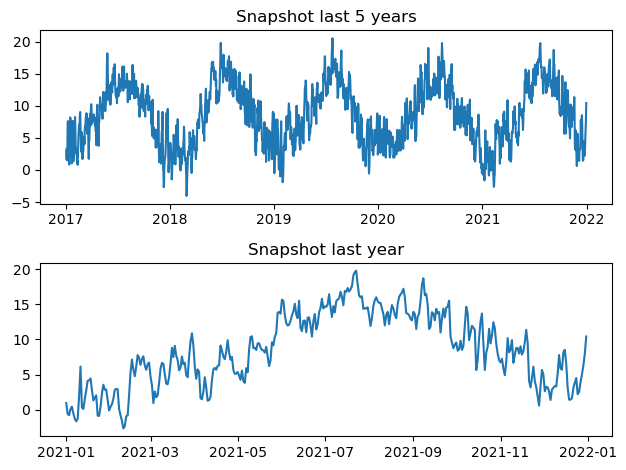

In [8]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(df['date'][-5*365:], df['avg'][-5*365:])
axs[0].set_title("Snapshot last 5 years")
axs[1].plot(df['date'][-365:], df['avg'][-365:])
axs[1].set_title("Snapshot last year")
fig.tight_layout()
plt.show()

### Modelling

#### Optimal Climatological Normal

The most intuiative model would be to model the temperature in a given period (e.g. month, day) as Gaussian over historical data. The climatological normal or climate normal (CN) is a 30-year average of a weather variable for a given time of year. Due to the affects of climate change, we observe an upwards trend in the average temperature year and year, this indicates climate normals are non-stationary and therefore a Gaussian model is no longer appropriate in modelling. They are however appropriate in measuring the severity of climate change, if we observe temperatures statistically significantly above our climatelogical normal this indicates climate change is occuring, for example. As a result models such as the optimal climate normal, which is ‘a “smart” average where the data values tell you how many years to average over, are used now instead.

https://journals.ametsoc.org/view/journals/clim/9/4/1520-0442_1996_009_0827_ssolrc_2_0_co_2.xml 

#### Time Series Model

The success of a time series model depends on two objectives. Firstly, the data must be re-formulated into a stationary series and secondly a stationary model must be fit. 

We begin with constructing an elementary time series model of the data. We do this by decomposting the data into trend, seasonality and residual components,

$$ y_{t} = T_{t} + S_{t} + \epsilon_{t}.$$

We assume $T_{t}$ and $S_{t}$ are deterministic and that $\epsilon_{t}$ is random and mean zero. In our case we will assume the trend is monotone and the seasonal component periodic.

If we can find the deterministic terms in the data we can then use our time series models to estimate the error/residual term. Differencing can cancel any polynomial deterministic term in the data.

First we construct the trend component with a $10$ year moving average.

In [9]:
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults
from statsmodels.tsa.arima.model import ARIMA

Considering the decreasing trend of the peaks, we find the correlation between a day and the same day in subsequent years decreases over time.

/tmp/ipykernel_44849/1180238875.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


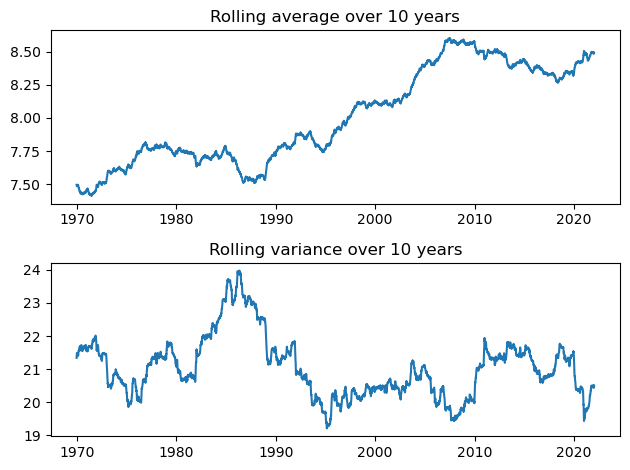

In [10]:
fig, axs = plt.subplots(2,1)
axs[0].plot(df['date'], df['avg'].rolling(window = 365*10).mean())
axs[0].set_title("Rolling average over 10 years")
axs[1].plot(df['date'], df['avg'].rolling(window = 365*10).var())
axs[1].set_title("Rolling variance over 10 years")
fig.tight_layout()
fig.show()

## Seasonal Decomposition

We now perform an additive seasonal decomposition of the data. 

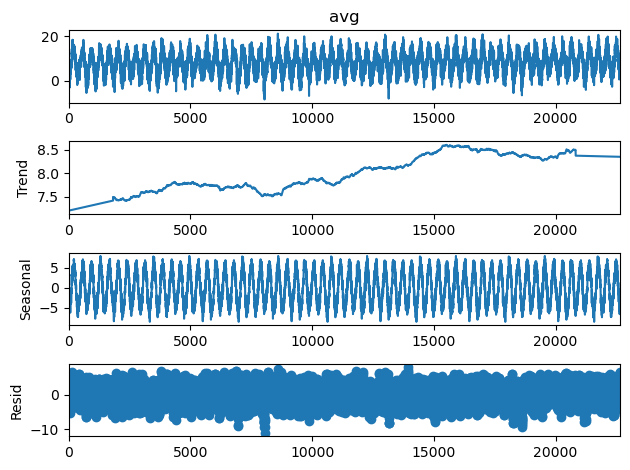

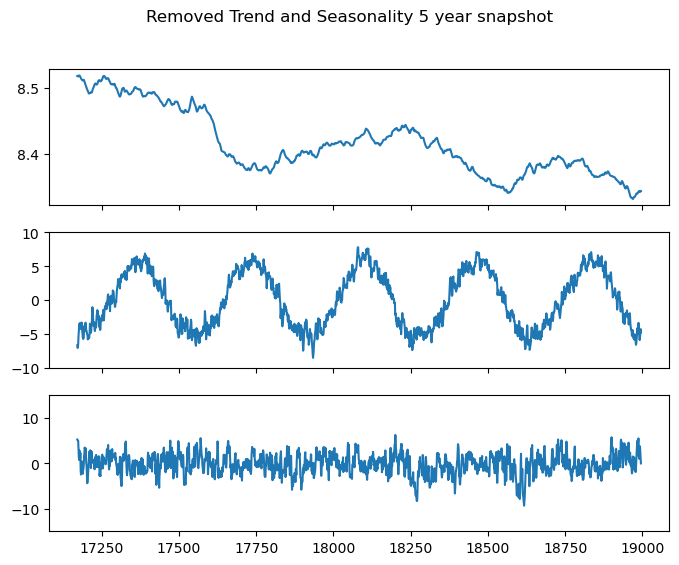

In [11]:
decompose_result = seasonal_decompose(df['avg'], model='additive', period=int(365*10), extrapolate_trend='freq')
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid
### Visualise All Data
decompose_result.plot()
plt.show()
### Visualise 10 years
years_examine_end = -365 * 10
years_examine_start = -365 * 15
fig, axs = plt.subplots(3, figsize=(8,6), sharex=True)
fig.suptitle('Removed Trend and Seasonality 5 year snapshot')
axs[0].plot(trend[years_examine_start:years_examine_end])
axs[1].plot(seasonal[years_examine_start:years_examine_end])
axs[1].set_ylim([-10,10])
axs[2].plot(residual[years_examine_start:years_examine_end])
axs[2].set_ylim([-15,15])
pass

### ARIMA (Auto-Regressive Interfaced Moving Average) model

We now attempt to model the residuals. To do this, we consider a ARIMA model. This is a combination of an Auto-regressive and Moving Average model. This is a model of stationary data, which is data that has the same joint distribution under translation in time. Formally this is given by:

$X_{t}$ is stationary if $\forall n \in N, ~\forall t_{1} < t_{2} < \dots < t_{n} \in T,\forall s > 0~\text{such that}~t_{n} + s \in T$ the joint cumulative distribution of $\{X_{t_{1}}, X_{t_{2}}, \dots, X_{t_{n}} \}$ is the same as the joint cumulative distribution of $\{X_{s + t_{1}}, X_{s + t_{2}}, \dots, X_{s + t_{n}} \}$.

Independence in time series doesn't make much sense but stationarity ensures that the series behaves the same across all points in time.

#### Auto-Regressive (AR) model

Forecast the time series with previous values, for example the AR(1) model (which notably recurses):

$$ Y_{t} = w + \theta Y_{t-1} + \epsilon_{t} $$ 

$$= w + \theta(w + \theta Y_{t-2} + \epsilon_{t-1}) + \epsilon_{t} = w^{*} + \theta^{2}Y_{t-2} + \theta\epsilon_{t-1} + \epsilon_{t} = \dots = w^{*} + \theta^{k} Y_{t-k} + \sum_{i=0}^{k} \theta^{k}\epsilon_{t-k}.$$

Due to this formulation it is a `long-memory' model. The general AR(p) model is given by:

$$ Y_{t} = w + \theta_{1} Y_{t-1} + \dots + \theta_{p} Y_{t-p} + \epsilon_{t}. $$

The parameters $\theta_{1}, \dots, \theta_{p}$ can be determined via a system of linear equations in terms of the auto-correlation of the time series. These are known as the Yule-Walker equations of the AR model. Of course, an AR(p) model requires requires knowing (or estimating) the first p+1 auto-correlations of the model $\gamma_{X}(0), \gamma_{X}(1), \dots, \gamma_{X}(p)$.

#### Moving Average (MA) model

Forecast the time series with previous errors, for example the MA(1) model is given by:

$$Y_{t} = w + \theta \epsilon_{t-1} + \epsilon_{t}.$$

This does not recurse and is therefore referred to as a `short-memory' model.

The general MA(q) model is given by:

$$ Y_{t} = w + \theta_{1} \epsilon_{t-1} + \dots + \theta_{q} \epsilon_{t-q} + \epsilon_{t}.$$

## Modelling the residuals

Firstly, let's look at a histogram of our residuals.

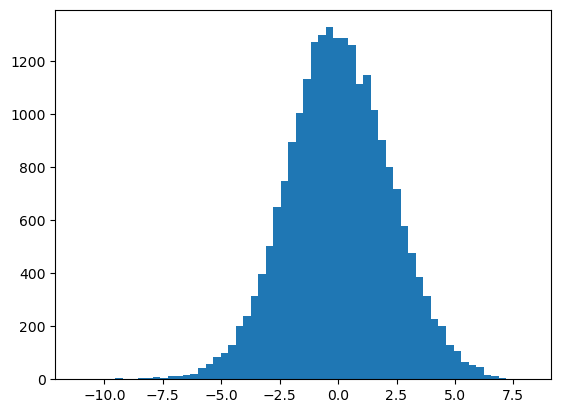

In [12]:
plt.hist(residual, bins=60)
plt.show()
pass

It looks symmetric about $0$ and in fact approximately Gaussian too. We can fit a Gaussian distribution to these residuals using a maximum likelihood estimator.

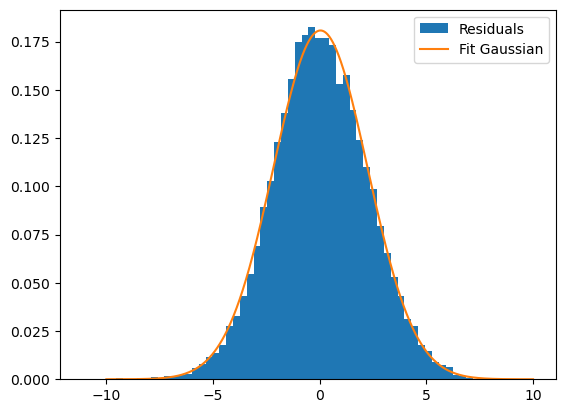

In [13]:
mu_mle = np.mean(residual)
sigma_mle = np.std(residual - np.mean(residual))
x = np.linspace(-10, 10, 1000)
pdf_values = norm.pdf(x, mu_mle, sigma_mle)
plt.hist(residual, bins=60, stacked=True, density=True, label="Residuals")
plt.plot(x, pdf_values, label="Fit Gaussian")
plt.legend()
plt.show()



Combining these models together, we the ARIMA model. As this is stationary, we need to first consider a stationary form of the data, this is usually done by taking differences. That is, even though $X_{t}$ may not be stationary, the series $Y_{t} = X_{t} - X_{t-1}$ may be. We can also consider the differences of $Y_{t}$, this is a second-order differences series. 

In order to check for stationarity we perform the Dickey-Fuller hypothesis test, with a p-value of $0.05$ (here we use the Akaike Information Criterion (AIC) to determine the number of previous terms to consider).

In [14]:
dftest = adfuller(residual, autolag='AIC')
print("ADF statistic: ", dftest[0])
print("P-Value : ", dftest[1])
print("Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

ADF statistic:  -25.0677380164358
P-Value :  0.0
Critical Values :
	 1% :  -3.430639088190931
	 5% :  -2.8616677676361624
	 10% :  -2.5668380070797716


This test implies our residuals are very stationary (p-value is $0.0 < 0.05$), we can plot a sample too. Therefore we can use a $0$ difference model on the residiuals. 

#### Parameter Selection

Now to determine the parameter $p$ for an AR model of the residuals. We consider the Akaike Information Criteron (AIC) which is given by:

$$ AIC = 2k - 2\ln(\hat{L})$$

Where $k$ is the number of learnable parameters and $\hat{L}$ is the maximised likelihood function of the model. We wish to take the value $k$ for which the AIC is minimised, therefore this is a tradeoff between model complexity and model fit.

#### Partial Auto-Correlation

The partial auto-correlation is correlation between the current term $Y_{t}$ and $Y_{t-k}$ accounting for any correlations caused by mutual correlation between terms in between. Essentially, it measures how much correlation just the two variables have. Assuming we pick $p$ correctly, we are accounting for all terms in the past which aid determining $Y_{t}$. Therefore the auto-correlation after this point should be near 0.

Under an AR model, the partial auto-correlation (which is the auto-correlation between the final term in our estimate and the true value) should be $0$. Therefore we can find $p$ by determining when the partial auto-correlation is $0$.

In order to do this we determine the lags of our partial auto-correlation plot and auto-correlation plot which are significantly out of the limit.

/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


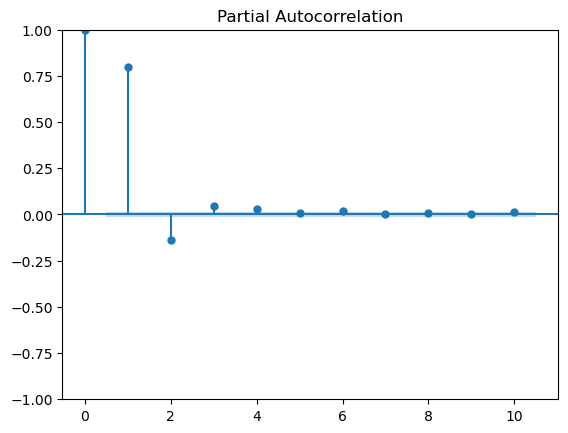

In [15]:
plot_pacf(residual, lags=10)
plt.show()

From the partial auto-correlation plot we see the first $3$ terms are significantly out side of the confidence interval (which identifies points statisitcally significant from zero) and therefore we can choose $p=6$ (so AR(6)) for a comprehensive fit.

This can be verified with the Akalide Information Criteron:

/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(
/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(
/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(
/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(
/home/peter/anaconda3/envs/urop-

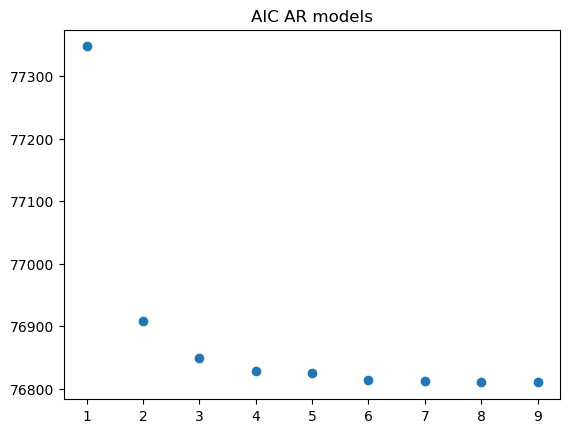

In [16]:
lag_parameters = np.arange(start=1, stop=10, step=1)
models = np.array([AutoReg(residual, lags=lag, old_names=True,trend='n') for lag in lag_parameters])
model_fits = np.array([model.fit() for model in models])
aics = np.array([model_fit.aic for model_fit in model_fits])

plt.scatter(lag_parameters, aics)
plt.title("AIC AR models")
plt.show()
pass

In [17]:
model_fit = AutoReg(residual, lags=6, old_names=True,trend='n').fit()
coef = model_fit.params
res = model_fit.resid
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                22646
Model:                     AutoReg(6)   Log Likelihood              -38400.040
Method:               Conditional MLE   S.D. of innovations              1.319
Date:                Fri, 11 Aug 2023   AIC                          76814.079
Time:                        14:05:24   BIC                          76870.272
Sample:                             6   HQIC                         76832.354
                                22646                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid.L1       0.9114      0.007    137.151      0.000       0.898       0.924
resid.L2      -0.1774      0.009    -19.728      0.000      -0.195      -0.160
resid.L3       0.0230      0.009      2.539      0.0

/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(


/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


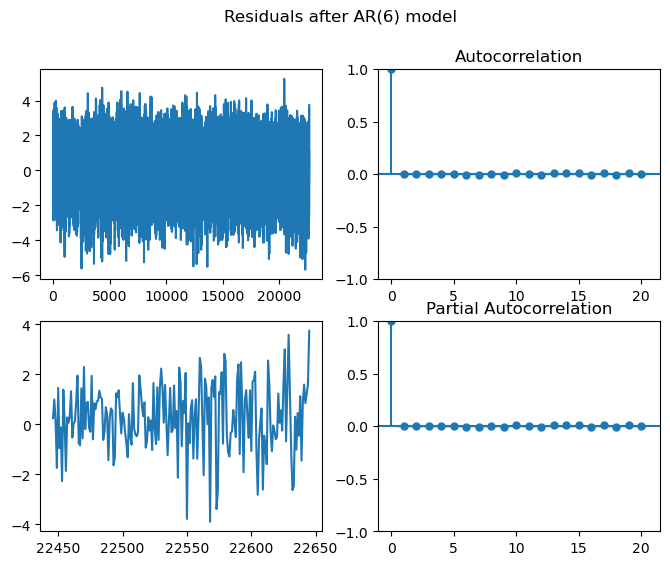

In [18]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Residuals after AR(6) model')
axs[0,0].plot(res)
axs[1,0].plot(res[-200:])
plot_acf(res, lags=20, ax=axs[0,1])
plot_pacf(res, lags=20, ax=axs[1,1])
plt.show()

Now we have a trend component, a seasonal component and an AR(6) model for our residuals.  

## Fourier Series

Time series decomposition

$$ Y_{t} = T_{t} + S_{t} + \epsilon_{t}.$$

+ **Trend ($T_{t}$)**: The underlying trajectory of the data over time. It is the long-term movement in data that can be upward, downward, or stagnant.
+ **Seasonality \($S_{t}$\)**: This captures the periodic fluctuations in the data. 
+ **Error \($\epsilon_{t}$\)**: Represents the randomness or noise in the data that cannot be attributed to the trend or seasonality. It is the residual difference after accounting for the first two terms.

### Denoising our data

In order to identify underlying trends in the data I will first apply a series of denoising techniques to the data:

#### Moving average

The simpliest way to remove noise from data is to take a moving average, if our data is of the form $Y_{t} = X_{t} + \epsilon_{t}$, with $\epsilon_{t} \sim N(0, \sigma^{2})$ then the error in moving average is $\frac{1}{N} \sum_{N} N(0, \sigma^{2}) = N(0, \frac{\sigma^{2}}{N})$. So the contribution of the noise terms in the moving average decreases as N increases, of course the more we average the less contribution we get from each point in the series too. 

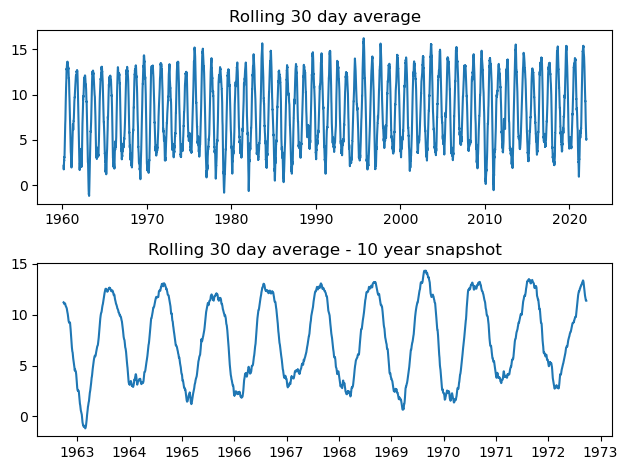

In [19]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(df['date'], df['avg'].rolling(window = 50).mean())
axs[0].set_title("Rolling 30 day average")
axs[1].plot(df['date'][1000:1000+365*10], df['avg'].rolling(window = 50).mean()[1000:1000+365*10])
axs[1].set_title("Rolling 30 day average - 10 year snapshot")
fig.tight_layout()
pass

We can also use an exponential moving average which gives geometric weightings to closer data points.

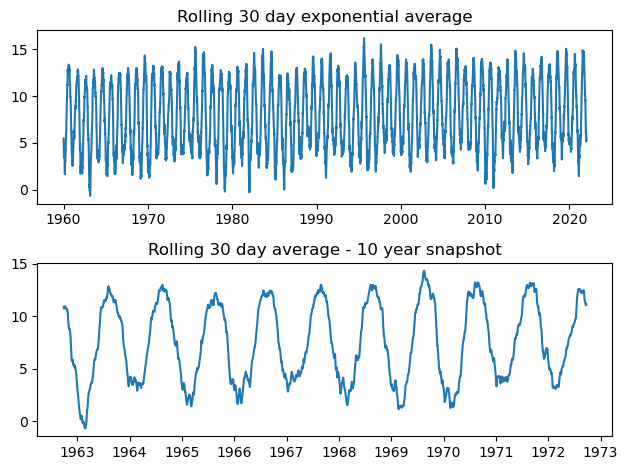

In [20]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(df['date'], df['avg'].ewm(span=50, adjust=False).mean())
axs[0].set_title("Rolling 30 day exponential average")
axs[1].plot(df['date'][1000:1000+365*10], df['avg'].ewm(span=50, adjust=False).mean()[1000:1000+365*10])
axs[1].set_title("Rolling 30 day average - 10 year snapshot")
fig.tight_layout()
pass

Or even a median average instead.

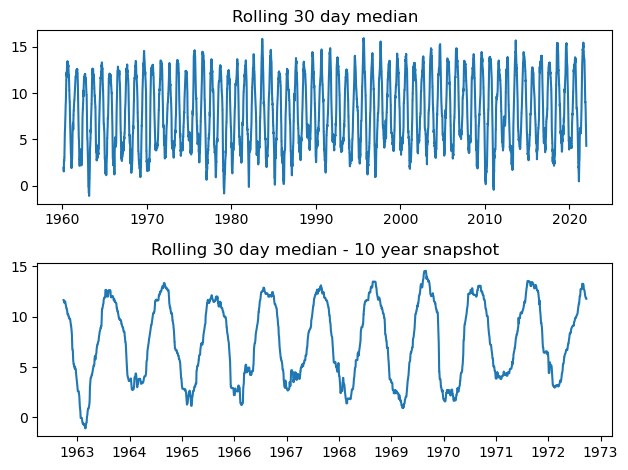

In [21]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(df['date'], df['avg'].rolling(window=50).median())
axs[0].set_title("Rolling 30 day median")
axs[1].plot(df['date'][1000:1000+365*10], df['avg'].rolling(window=50).median()[1000:1000+365*10])
axs[1].set_title("Rolling 30 day median - 10 year snapshot")
fig.tight_layout()
pass

#### Convolution

A convolution of $g$ by a function $f$ is the following operation:

$$ (f * g) (x) = \int_{-\infty}^{\infty} f(\tau)g(x-\tau) dx .$$

This can be interpreted of a weighted average around g(x) where the weights are determiend by $f(x)$.

#### Gaussian Filters
A notable example of denoising are Gaussian filters. In this model, each point is averaged with the points around it, the weightings are specified by the Gaussian pdf centered around the point with some chosen variance. The variance corresponds to how much we want points further away to contribute to the average. Therefore a higher variance will produce a smoother result, while a lower variance will preserve more of the data's original features.

A continuous Gaussian filter is exactly a convolution where $f$ is the Gaussian probability density function.

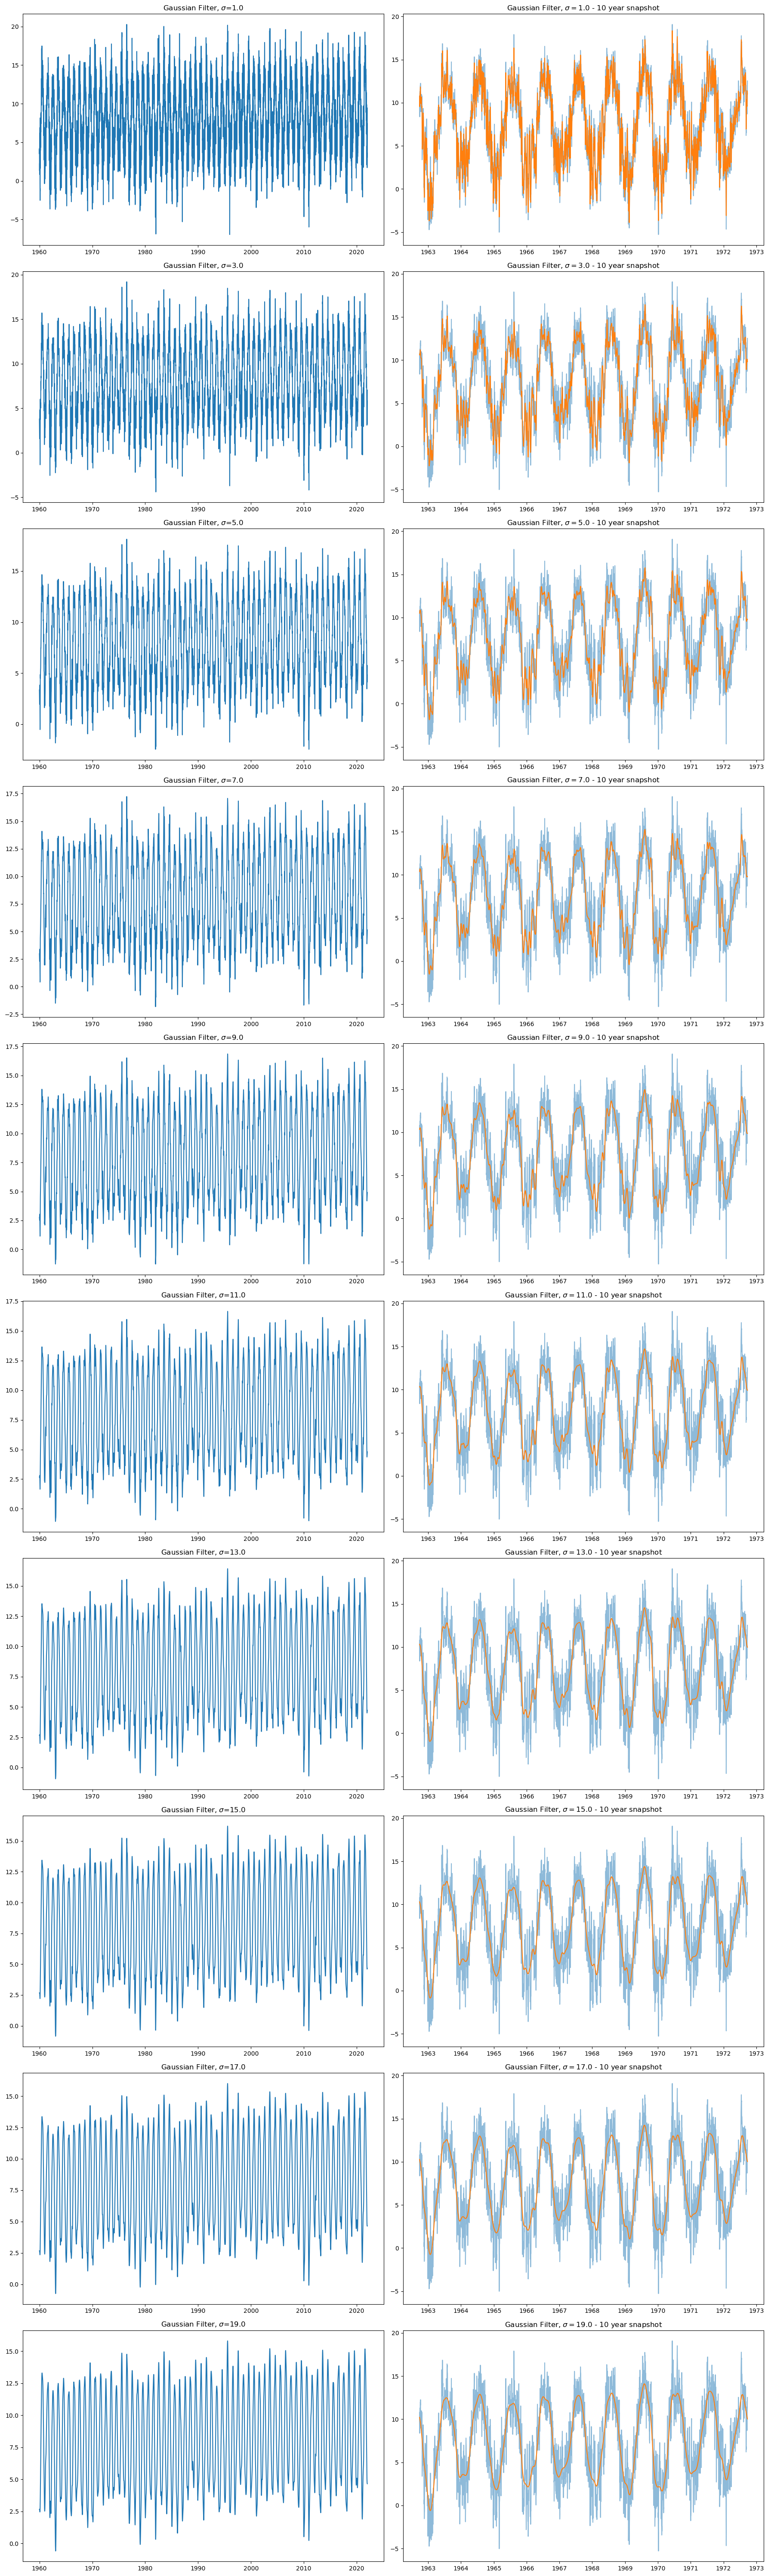

In [22]:
num_gf_sigmas = 10
gaussian_filter_sigmas = np.linspace(1, 19, num=num_gf_sigmas)
fig, axs = plt.subplots(10, 2)
fig.set_figwidth(18)
fig.set_figheight(num_gf_sigmas * 6)
for i, sigma in enumerate(gaussian_filter_sigmas):
    axs[i, 0].plot(df['date'], gaussian_filter(df['avg'], sigma=sigma))
    axs[i, 0].set_title(f"Gaussian Filter, $\sigma$={sigma}")
    axs[i, 1].plot(df['date'][1000:1000+365*10], df['avg'][1000:1000+365*10], alpha=0.5)
    axs[i, 1].plot(df['date'][1000:1000+365*10], gaussian_filter(df['avg'], sigma=sigma)[1000:1000+365*10])
    axs[i, 1].set_title(f"Gaussian Filter, $\sigma={sigma}$ - 10 year snapshot")
fig.tight_layout()

From this we can see $\sigma=15.0$ gives a good balance between smoothening and keeping data structure.

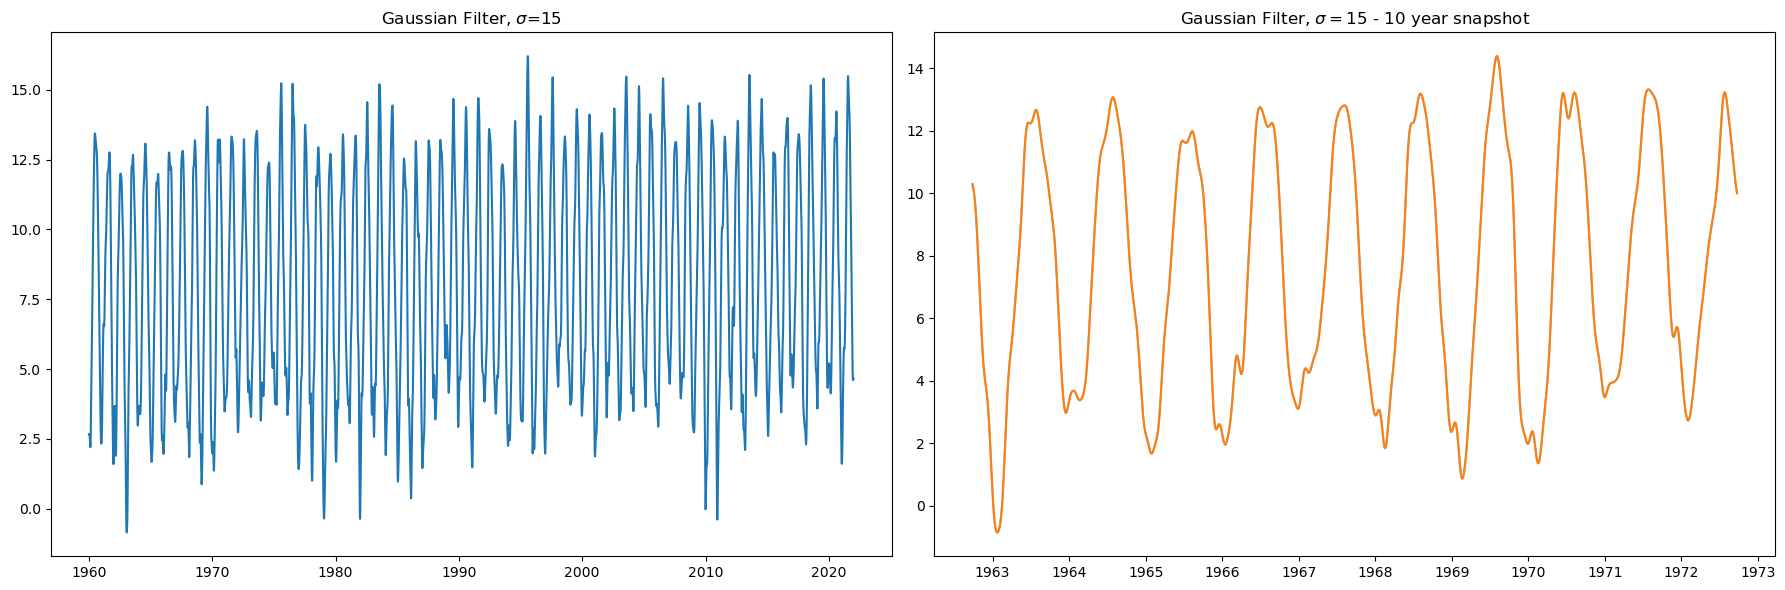

In [51]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.set_figheight(6)
denoised_gaussian_filter = gaussian_filter(df['avg'], sigma=15)
axs[0].plot(df['date'], denoised_gaussian_filter)
axs[0].set_title(f"Gaussian Filter, $\sigma$={15}")
axs[1].plot(df['date'][1000:1000+365*10], denoised_gaussian_filter[1000:1000+365*10], alpha=0.5)
axs[1].plot(df['date'][1000:1000+365*10], denoised_gaussian_filter[1000:1000+365*10])
axs[1].set_title(f"Gaussian Filter, $\sigma={15}$ - 10 year snapshot")
fig.tight_layout()

Now we have de-noised the data we will attempt to fit our first model.

/tmp/ipykernel_44849/742926294.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


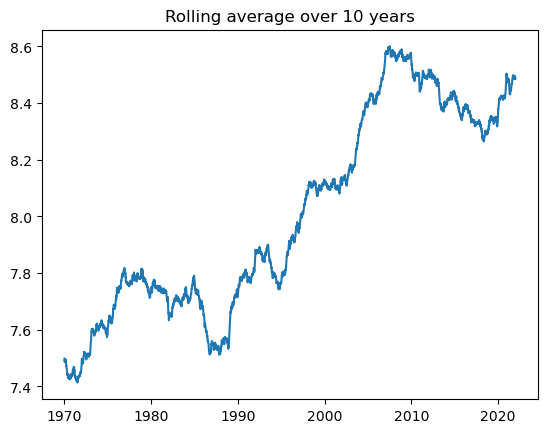

In [47]:
fig, axs = plt.subplots(1)
axs.plot(df['date'], df['avg'].rolling(window = 365*10).mean())
axs.set_title("Rolling average over 10 years")
fig.show()
pass

While the gradient is evidently non-constant we can approximately fit a straight-line via least squares regression. In LSR we aim to minimise the square of the residuals.

$$ L = \frac{1}{N}\sum (a + bt_{i} - T_{i})^{2}.$$
$$ \frac{\partial L}{\partial a} = 2 \frac{1}{N}\sum (a + bt - T_{i}) = 0 \implies a = \frac{1}{N}\sum (T_{i} - bt_{i}).$$
$$ \frac{\partial L}{\partial b} = 2 \frac{1}{N}\sum t(a + bt - T_{i}) = 0 \implies \dots $$

Theta_best: [7.23122408e+00 5.92407918e-05]


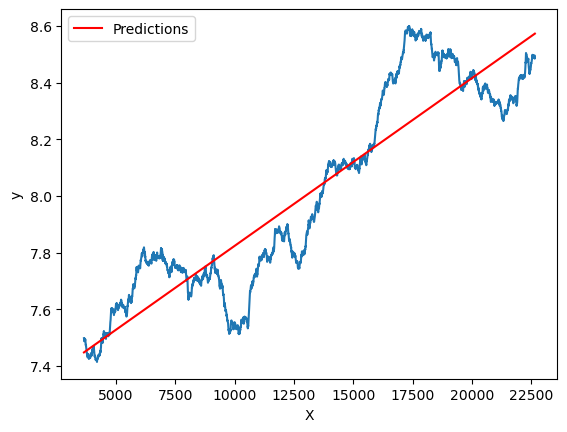

In [60]:
avg_temps = np.copy(df['avg'].rolling(window = 365*10).mean())
X = np.arange(len(avg_temps))
X = X[~np.isnan(avg_temps)]
avg_temps = avg_temps[~np.isnan(avg_temps)]
X_b = np.c_[np.ones((X.shape[0], 1)), X]
# Calculate coefficients using the normal equation
theta_best = np.linalg.inv(X_b.T@(X_b))@(X_b.T)@(avg_temps)
print(f"Theta_best: {theta_best}")
# Prediction
X_new = np.array([[np.min(X)], [np.max(X)]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

# Plotting
plt.plot(X, avg_temps)
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

Now we have our linear model, we can subtract this model from the denoised data to remove the trend, this will enable us to model the seasonality.

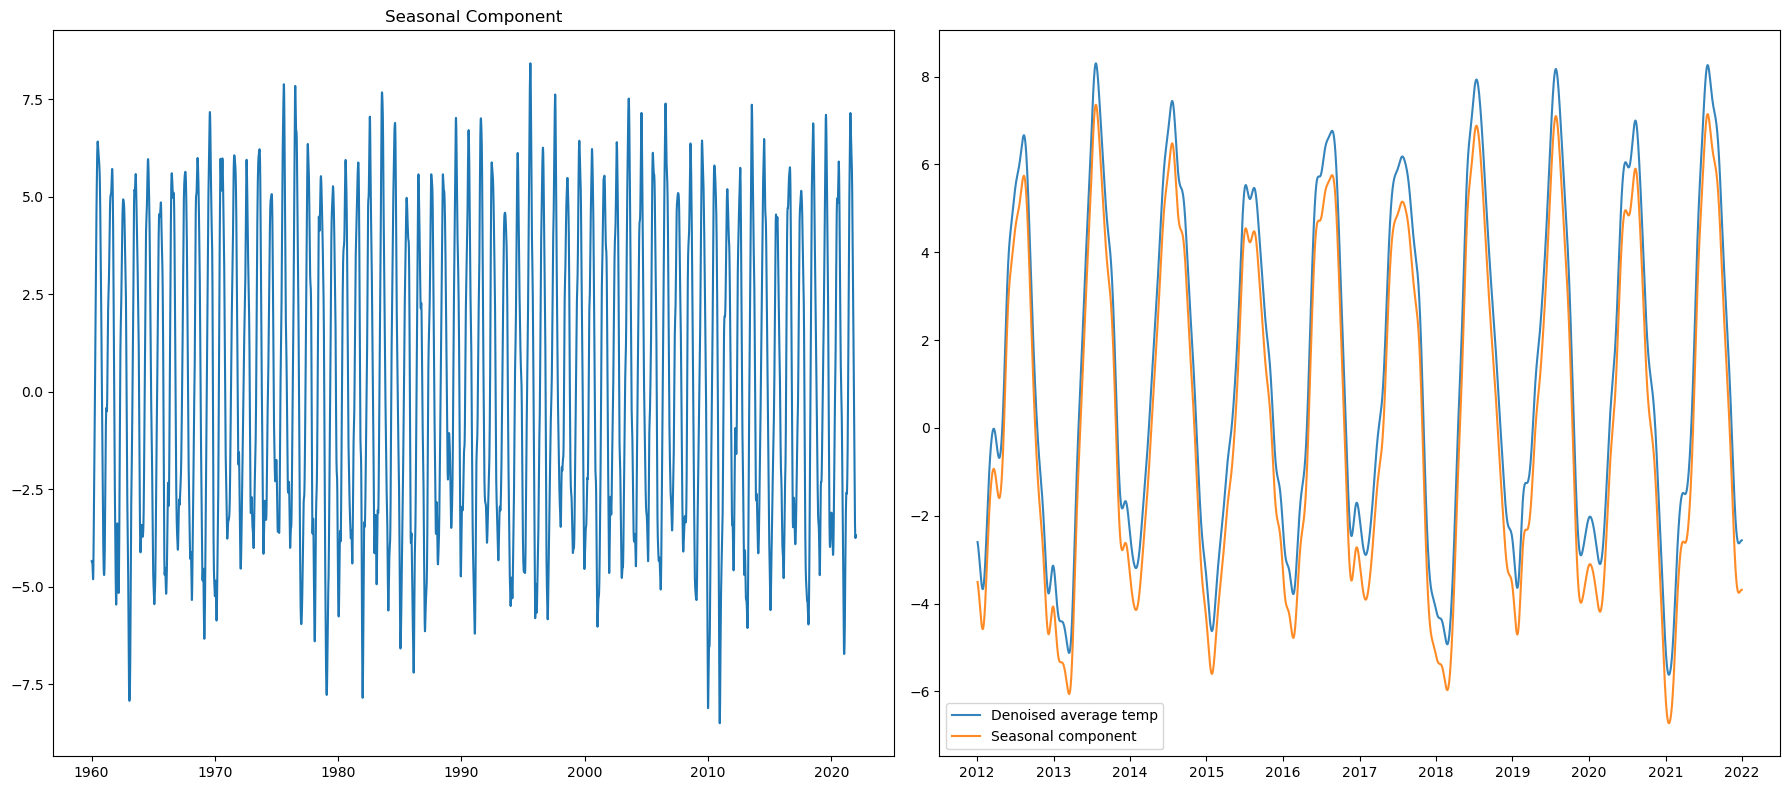

In [63]:
ts = np.arange(len(denoised_gaussian_filter))
seasonal_component = denoised_gaussian_filter - (theta_best[0] + theta_best[1] * (ts - 3649))
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.set_figheight(8)

axs[0].plot(df['date'], seasonal_component, label="Seasonal component")
axs[0].set_title("Seasonal Component")

axs[1].plot(df['date'][-365*10:], (denoised_gaussian_filter - theta_best[0])[-365*10:], label="Denoised average temp", alpha=0.9)
axs[1].plot(df['date'][-365*10:], seasonal_component[-365*10:], label="Seasonal component", alpha=0.9)
axs[1].legend()
fig.tight_layout()
plt.show()

Now we wish to fit a fourier series to the seasonal component. Following what is suggested by the literatue we will use the following:

$$T_{seasonal} = a\sin(\omega t + \phi)$$

Here, as we know the phase is $\frac{2\pi}{365.25}$, we will not leave this as a learnable parameter in our model. T

In [68]:
def model_seasonality(x, a, phi):
    return a * np.sin((2 * np.pi)/(365.25) * x + phi)

popt, pcov = curve_fit(model_seasonality, ts, seasonal_component)
print(f"Fit model parameters: a = {popt[0]}, phi = {popt[1]}.")

Fit model parameters: a = -5.339954879791876, phi = 1.1556909785673208.


Putting our model together now, we have:

$$ T_{t} = 7.23122408 + 5.92407918\cdot10^{-05}~(t - 3649) - 5.4 \sin(\frac{2\pi}{365.25} + 1.1557).$$

We can plot our model against the actual data:


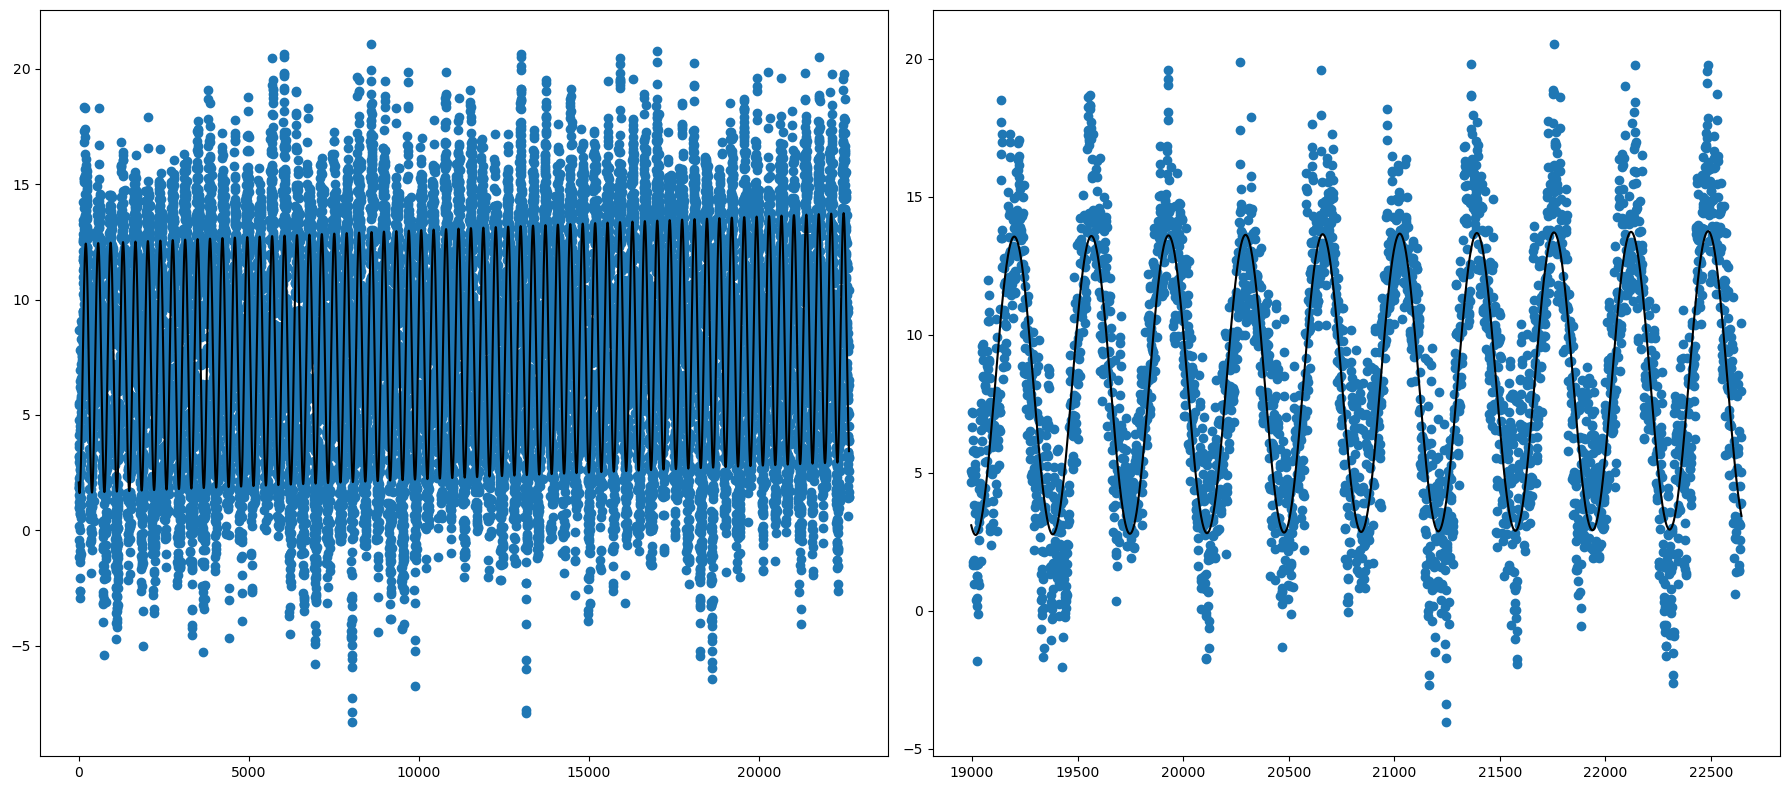

In [72]:
def fourier_model(t):
    return 7.23122408 + 5.92407e-5 * (t - 3649) - 5.4 * np.sin((2 * np.pi / 365.25)*t + 1.1557)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(18)
fig.set_figheight(8)

axs[0].scatter(ts, df['avg'])
axs[0].plot(ts, fourier_model(ts), linestyle='-', color='k')

axs[1].scatter(ts[-365*10:], df['avg'][-365*10:])
axs[1].plot(ts[-365*10:], fourier_model(ts)[-365*10:], linestyle='-', color='k')

fig.tight_layout()
plt.show()

From these plots it appears as though our model is not able to model areas of high volatility very well, this appears to be at the peak around seasons, in the summer and winter. In order to investigate this further we will look at the residuals of our model.


In [78]:
fourier_residuals = df['avg'] - fourier_model(ts) 

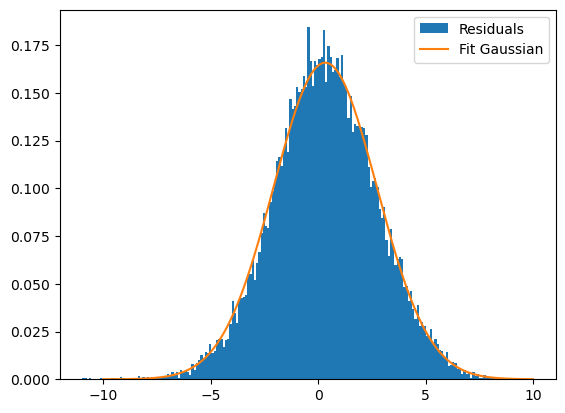

In [79]:
mu_mle = np.mean(fourier_residuals)
sigma_mle = np.std(fourier_residuals - np.mean(fourier_residuals))
x = np.linspace(-10, 10, 1000)
pdf_values = norm.pdf(x, mu_mle, sigma_mle)
plt.hist(fourier_residuals, bins=190, stacked=True, density=True, label="Residuals")
plt.plot(x, pdf_values, label="Fit Gaussian")
plt.legend()
plt.show()

/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


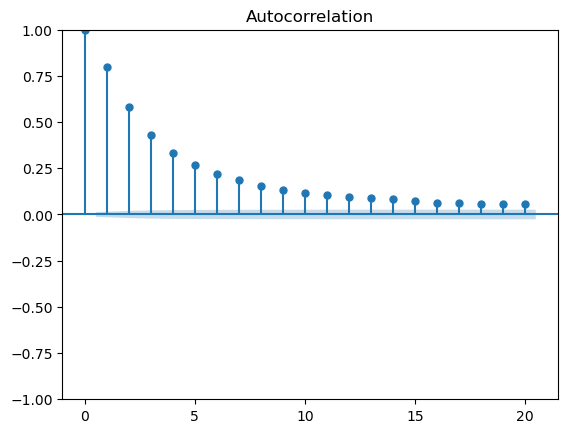

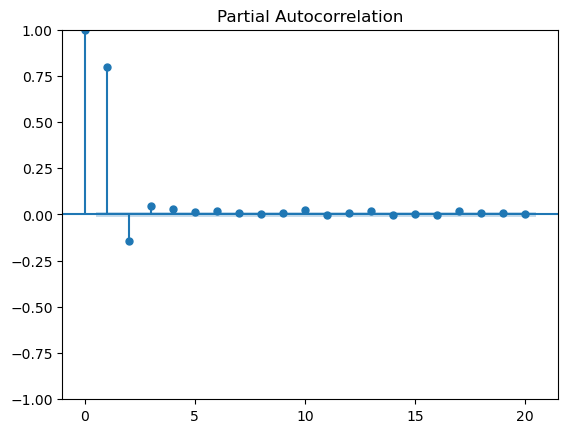

In [81]:
plot_acf(fourier_residuals, lags=20)
plot_pacf(fourier_residuals, lags=20)
plt.show()

As we can see here there is significant partial auto-correlation between the first term and subsequent terms in the series. This can be accounted for potentially in an AR model.

/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/tsa/ar_model.py:233: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  warnings.warn(
/home/peter/anaconda3/envs/urop-env/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


                            AutoReg Model Results                             
Dep. Variable:                    avg   No. Observations:                22646
Model:                     AutoReg(2)   Log Likelihood              -40445.425
Method:               Conditional MLE   S.D. of innovations              1.444
Date:                Fri, 11 Aug 2023   AIC                          80896.850
Time:                        16:40:25   BIC                          80920.933
Sample:                             2   HQIC                         80904.682
                                22646                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
avg.L1         0.9117      0.007    138.553      0.000       0.899       0.925
avg.L2        -0.1399      0.007    -21.258      0.000      -0.153      -0.127
                                    Roots           

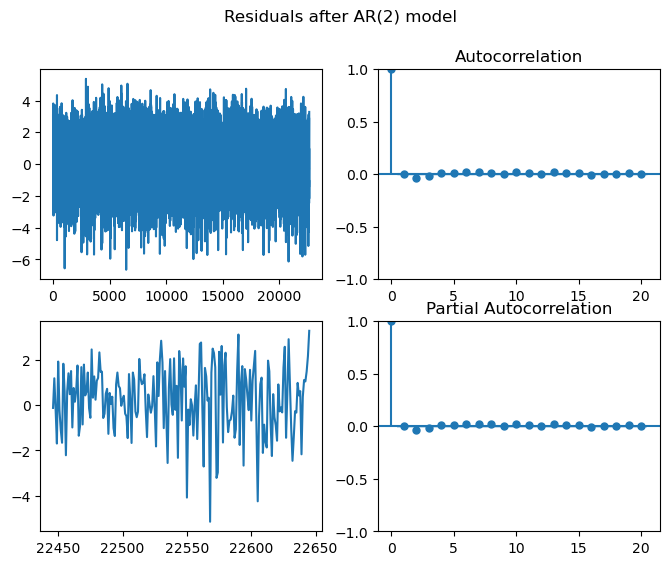

In [82]:
model_fit = AutoReg(fourier_residuals, lags=2, old_names=True,trend='n').fit()
coef = model_fit.params
res = model_fit.resid
print(model_fit.summary())

fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Residuals after AR(2) model')
axs[0,0].plot(res)
axs[1,0].plot(res[-200:])
plot_acf(res, lags=20, ax=axs[0,1])
plot_pacf(res, lags=20, ax=axs[1,1])
plt.show()

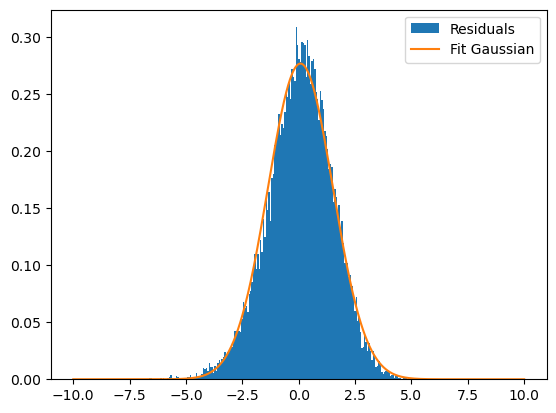

In [83]:
mu_mle = np.mean(res)
sigma_mle = np.std(res - np.mean(res))
x = np.linspace(-10, 10, 1000)
pdf_values = norm.pdf(x, mu_mle, sigma_mle)
plt.hist(res, bins=190, stacked=True, density=True, label="Residuals")
plt.plot(x, pdf_values, label="Fit Gaussian")
plt.legend()
plt.show()

#### Model Comparison

Can compare climateological daily models on past 5, 10, 15, 20, 25, 30 years. Can use a withheld time period to measure log likelihood.